# Master dissertation
## Development of videogames recommendation system with artificial intelligence
#### Author: Pedro Antonio Peña Puente 

## 1 - Preprocessing

### 1.1 - Importing libraries and loading Dataset

First of all, we need to import the libraries and the dataset we want to use 

In [1]:
# Import libraries
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras

# Check versions of libraries installed
print("System version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))
print("Tensorflow version: {}".format(tf.__version__))
print("Keras version: {}".format(keras.__version__))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2025-01-13 16:25:06.135649: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-13 16:25:06.182034: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-13 16:25:06.941118: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


System version: 3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]
Pandas version: 2.2.3
Tensorflow version: 2.13.0
Keras version: 2.13.1
Num GPUs Available:  0


2025-01-13 16:25:07.752104: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2025-01-13 16:25:07.752131: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: pc-pedro
2025-01-13 16:25:07.752135: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: pc-pedro
2025-01-13 16:25:07.752230: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.216.3
2025-01-13 16:25:07.752241: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.216.3
2025-01-13 16:25:07.752244: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 535.216.3


In [2]:
# In order to make quicker the training process, we create a function to reduce the weight of the data type
def reduce_memory(df):
    for col in df.columns:
        if df[col].dtype == 'float64':
            df[col] = df[col].astype('float32')
        elif df[col].dtype == 'int64':
            df[col] = df[col].astype('int32')
    return df

In [3]:
# We load the data
# Load games data
games = reduce_memory(pd.read_csv("/home/pedro/Master_python/TFM/data/games.csv"))
games.head()

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck
0,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.0,True
1,22364,BRINK: Agents of Change,2011-08-03,True,False,False,Positive,85,21,2.99,2.99,0.0,True
2,113020,Monaco: What's Yours Is Mine,2013-04-24,True,True,True,Very Positive,92,3722,14.99,14.99,0.0,True
3,226560,Escape Dead Island,2014-11-18,True,False,False,Mixed,61,873,14.99,14.99,0.0,True
4,249050,Dungeon of the ENDLESS™,2014-10-27,True,True,False,Very Positive,88,8784,11.99,11.99,0.0,True


In [4]:
# Load recommendations data
recommendations = reduce_memory(pd.read_csv("/home/pedro/Master_python/TFM/data/recommendations.csv"))
recommendations.head()

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
0,975370,0,0,2022-12-12,True,36.299999,51580,0
1,304390,4,0,2017-02-17,False,11.500000,2586,1
2,1085660,2,0,2019-11-17,True,336.500000,253880,2
3,703080,0,0,2022-09-23,True,27.400000,259432,3
4,526870,0,0,2021-01-10,True,7.900000,23869,4


In [5]:
# Load users data
users = reduce_memory(pd.read_csv("/home/pedro/Master_python/TFM/data/users.csv"))
users.head()

,user_id,products,reviews
0,7360263,359,0
1,14020781,156,1
2,8762579,329,4
3,4820647,176,4
4,5167327,98,2


In [6]:
# Load games metadata
games_metadata = pd.read_json('/home/pedro/Master_python/TFM/data/games_metadata.json', lines=True)
games_metadata.head()

,app_id,description,tags
0,13500,Enter the dark underworld of Prince of Persia ...,"[Action, Adventure, Parkour, Third Person, Gre..."
1,22364,,[Action]
2,113020,Monaco: What's Yours Is Mine is a single playe...,"[Co-op, Stealth, Indie, Heist, Local Co-Op, St..."
3,226560,Escape Dead Island is a Survival-Mystery adven...,"[Zombies, Adventure, Survival, Action, Third P..."
4,249050,Dungeon of the Endless is a Rogue-Like Dungeon...,"[Roguelike, Strategy, Tower Defense, Pixel Gra..."


### 1.2 - Exploring data

Lets explore the data and their characteristics

In [7]:
# Check the columns information
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50872 entries, 0 to 50871
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   app_id          50872 non-null  int32  
 1   title           50872 non-null  object 
 2   date_release    50872 non-null  object 
 3   win             50872 non-null  bool   
 4   mac             50872 non-null  bool   
 5   linux           50872 non-null  bool   
 6   rating          50872 non-null  object 
 7   positive_ratio  50872 non-null  int32  
 8   user_reviews    50872 non-null  int32  
 9   price_final     50872 non-null  float32
 10  price_original  50872 non-null  float32
 11  discount        50872 non-null  float32
 12  steam_deck      50872 non-null  bool   
dtypes: bool(4), float32(3), int32(3), object(3)
memory usage: 2.5+ MB


In [8]:
# Check the columns information
recommendations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41154794 entries, 0 to 41154793
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   app_id          int32  
 1   helpful         int32  
 2   funny           int32  
 3   date            object 
 4   is_recommended  bool   
 5   hours           float32
 6   user_id         int32  
 7   review_id       int32  
dtypes: bool(1), float32(1), int32(5), object(1)
memory usage: 1.3+ GB


In [9]:
# Check the columns information
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14306064 entries, 0 to 14306063
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int32
 1   products  int32
 2   reviews   int32
dtypes: int32(3)
memory usage: 163.7 MB


In [10]:
# Check the columns information
games.columns

Index(['app_id', 'title', 'date_release', 'win', 'mac', 'linux', 'rating',
       'positive_ratio', 'user_reviews', 'price_final', 'price_original',
       'discount', 'steam_deck'],
      dtype='object')

Lets start the data exploration checking how many games release on each year

In [11]:
# Check null values
games['date_release'].isnull().sum()

0

In [12]:
# Convert the date columns to datetime
games['date_release'] = pd.to_datetime(games['date_release'])
games['release_year'] = games['date_release'].dt.year

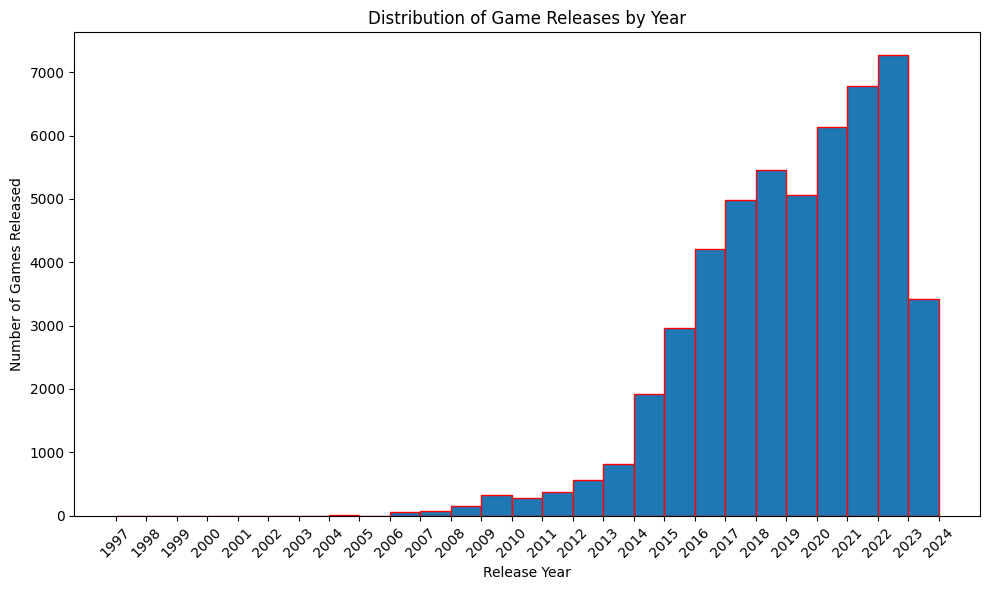

In [13]:
# Draw a histogram of the number of games released by year
plt.figure(figsize=(10, 6))
plt.hist(games['release_year'], bins=range(min(games['release_year']), max(games['release_year']) + 2), edgecolor='red')
plt.title('Distribution of Game Releases by Year')
plt.xlabel('Release Year')
plt.ylabel('Number of Games Released')
plt.xticks(range(min(games['release_year']), max(games['release_year']) + 2))
plt.xticks(rotation=45)
plt.tight_layout()

As we can, see the amount of games realesed has an positive trend year by year

Now we will see what percentage of games support Windows, Linux and MacOS

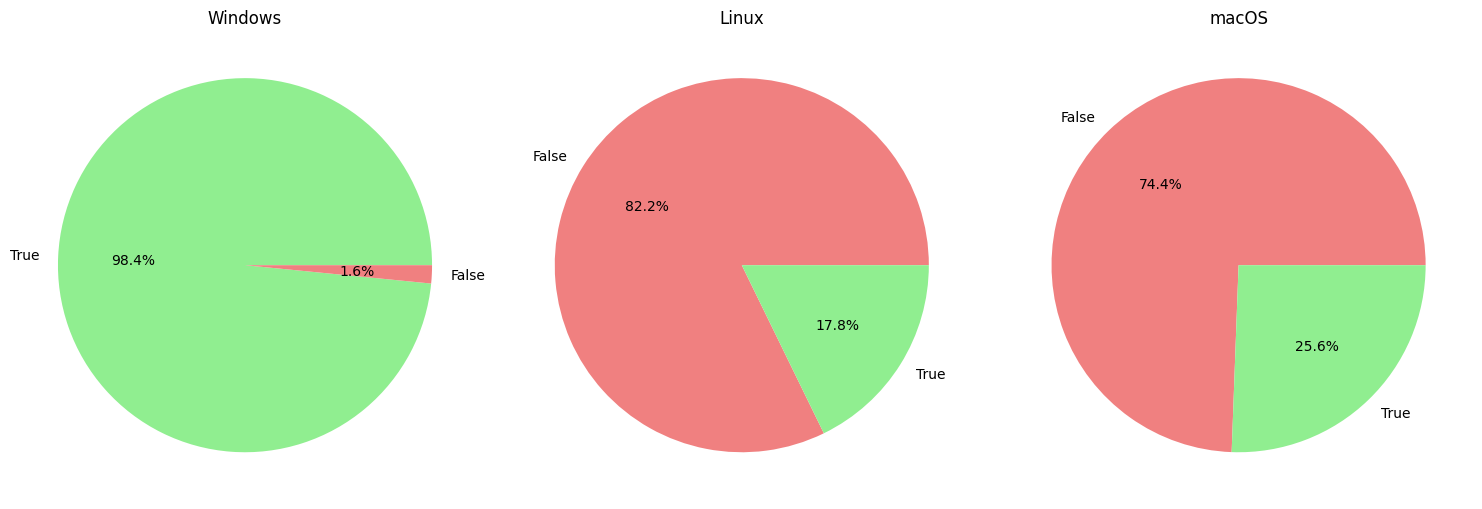

In [14]:
# Count the number of True values per platform
counts_win = games['win'].value_counts()
counts_linux = games['linux'].value_counts()
counts_mac = games['mac'].value_counts()

# Draw a pie chart of the distribution of games by platform
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# pie chart for Windows
axs[0].pie(counts_win, labels=counts_win.index, autopct='%1.1f%%', colors=['lightgreen', 'lightcoral']) 
axs[0].set_title('Windows')
# autopct format the percentage to format 17.8%

# pie chart for Linux
axs[1].pie(counts_linux, labels=counts_linux.index, autopct='%1.1f%%', colors=['lightcoral', 'lightgreen'])
axs[1].set_title('Linux')

# pie chart for macOS
axs[2].pie(counts_mac, labels=counts_mac.index, autopct='%1.1f%%', colors=['lightcoral', 'lightgreen'])
axs[2].set_title('macOS')

# Fit the layout
plt.tight_layout()

Now, lets check the amount of positively rated games

In [15]:
games['rating'].unique()

array(['Very Positive', 'Positive', 'Mixed', 'Mostly Positive',
       'Overwhelmingly Positive', 'Negative', 'Mostly Negative',
       'Overwhelmingly Negative', 'Very Negative'], dtype=object)

/tmp/ipykernel_1322598/2660493765.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot( x='rating' , data = games ,


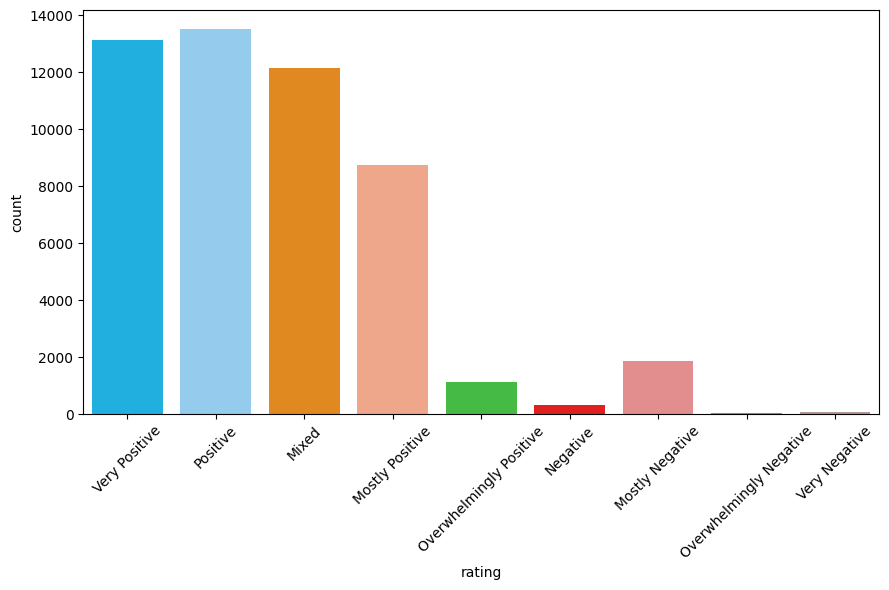

In [16]:
# Plot a bar chart with the number of games per rating
plt.figure(figsize=(9, 6))
sns.countplot( x='rating' , data = games , 
    palette = [
    'DeepSkyBlue',        # Very Positive
    'LightSkyBlue',       # Positive
    'DarkOrange',         # Mixed
    'LightSalmon',        # Mostly Positive
    'LimeGreen',          # Overwhelmingly Positive
    'Red',                # Negative
    'LightCoral',         # Mostly Negative
    'MediumPurple',       # Overwhelmingly Negative
    'RosyBrown'           # Very Negative
])
plt.xticks(rotation=45)
plt.tight_layout()

In [17]:
print("Number of Positively Rated Games (Rating > 70) :- ",(games[games['positive_ratio'] >= 70].shape[0] / games.shape[0]) * 100)
print("Number of Negatively Rated Games (Rating < 70) :- ",(games[games['positive_ratio'] < 70].shape[0] / games.shape[0]) * 100)

Number of Positively Rated Games (Rating > 70) :-  71.72707972951721
Number of Negatively Rated Games (Rating < 70) :-  28.272920270482782


In [18]:
# Now lets explore the game prices
print(f"The cheapest game cost {round(min(games['price_final']),2)}$")
print(f"The most expensive game cost {round(max(games['price_final']),2)}$")

price_bins = [0, 50, 100, float('inf')] 

price_labels = ['Low-priced', 'Medium-priced', 'High-priced']

# 'price_category' based on price bins
games['price_category'] = pd.cut(games['price_final'], bins=price_bins, labels=price_labels)

# Group by price category and calculate mean positive ratio and mean user reviews for each category
segmented_analysis = games.groupby('price_category').agg({
    'positive_ratio': 'mean',
    'user_reviews': 'mean'
})

print(segmented_analysis)

The cheapest game cost 0.0$
The most expensive game cost 299.99$
                positive_ratio  user_reviews
price_category                              
Low-priced           77.296487   1574.153404
Medium-priced        70.750533  10344.377399
High-priced          78.892857     36.357143


/tmp/ipykernel_1322598/3260765302.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segmented_analysis = games.groupby('price_category').agg({


In [19]:
# Show the games data
games.head()

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck,release_year,price_category
0,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.0,True,2008,Low-priced
1,22364,BRINK: Agents of Change,2011-08-03,True,False,False,Positive,85,21,2.99,2.99,0.0,True,2011,Low-priced
2,113020,Monaco: What's Yours Is Mine,2013-04-24,True,True,True,Very Positive,92,3722,14.99,14.99,0.0,True,2013,Low-priced
3,226560,Escape Dead Island,2014-11-18,True,False,False,Mixed,61,873,14.99,14.99,0.0,True,2014,Low-priced
4,249050,Dungeon of the ENDLESS™,2014-10-27,True,True,False,Very Positive,88,8784,11.99,11.99,0.0,True,2014,Low-priced


In [20]:
# Show the users data
users.head()

,user_id,products,reviews
0,7360263,359,0
1,14020781,156,1
2,8762579,329,4
3,4820647,176,4
4,5167327,98,2


In [21]:
# Show the recommendations data
recommendations.head()

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
0,975370,0,0,2022-12-12,True,36.299999,51580,0
1,304390,4,0,2017-02-17,False,11.500000,2586,1
2,1085660,2,0,2019-11-17,True,336.500000,253880,2
3,703080,0,0,2022-09-23,True,27.400000,259432,3
4,526870,0,0,2021-01-10,True,7.900000,23869,4


In [22]:
# Check the unique users
# Here User_ID is auto genrated id due to privacy concerns
users['user_id'].unique().shape[0]

14306064

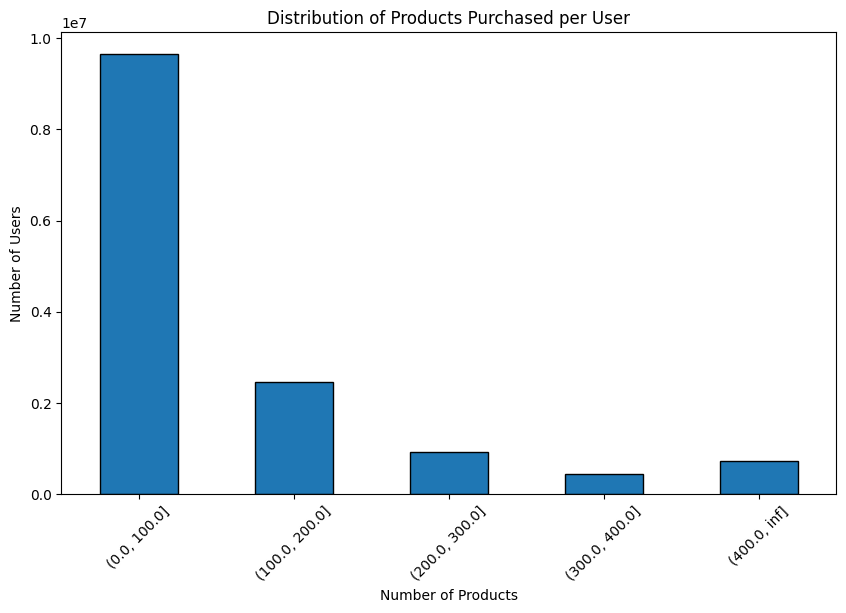

In [23]:
# Plot the amount of products purchased by user
# Create bins for the number of products
bins = [0 , 100 , 200 , 300 , 400 , float('inf')]
users['product_bin'] = pd.cut(users['products'], bins=bins)

# Count the number of users in each bin
bin_counts = users['product_bin'].value_counts().sort_index()

# Plot a bar plot of the distribution of products per user
plt.figure(figsize=(10, 6))
bin_counts.plot(kind='bar', edgecolor='black')
plt.title('Distribution of Products Purchased per User')
plt.xlabel('Number of Products')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)
plt.show()

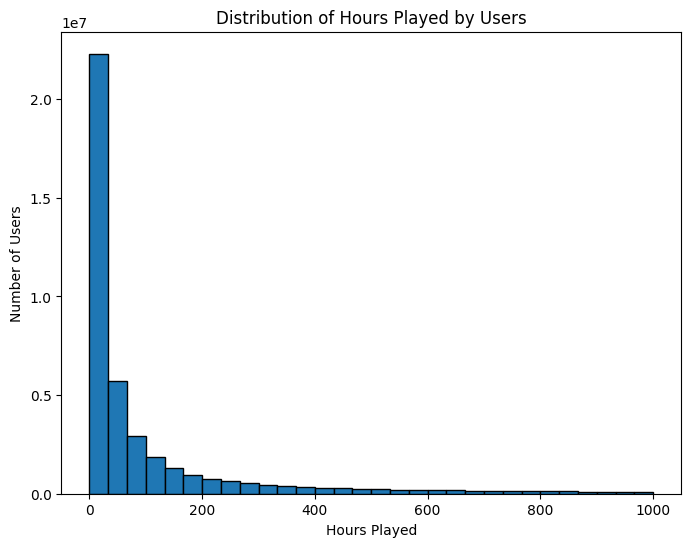

In [24]:
# Now lets explore the distribution of hours played by users
# Plot a bar plot with the distribution of hours played by users
plt.figure(figsize=(8, 6))
plt.hist(recommendations['hours'], bins=30, edgecolor='black')
plt.title('Distribution of Hours Played by Users')
plt.xlabel('Hours Played')
plt.ylabel('Number of Users')
plt.show()

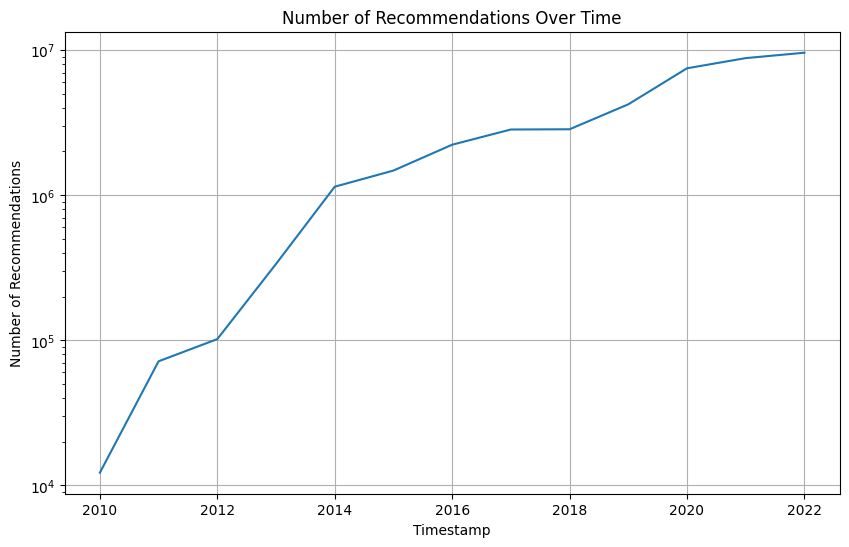

In [25]:
# Plot the development of recommendations over time
recommendations['date'] = pd.to_datetime(recommendations['date'])
recommendations['publish_year'] = recommendations['date'].dt.year

recommendations_by_time = recommendations['publish_year'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
plt.plot(recommendations_by_time.index, recommendations_by_time.values)
plt.title('Number of Recommendations Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Number of Recommendations')
plt.grid(True)
plt.yscale('log')
plt.show()

In [26]:
# Now lets see the correlation between reviews as helpful, funny and is_recommended
# Calculate the correlation matrix
correlation_matrix = recommendations[['helpful', 'funny', 'is_recommended']].corr()

print('Correlation Matrix:')
print(correlation_matrix)

Correlation Matrix:
                 helpful    funny  is_recommended
helpful         1.000000  0.48036       -0.026876
funny           0.480360  1.00000       -0.003370
is_recommended -0.026876 -0.00337        1.000000


In [27]:
# Now lets see the correlation between reviews and hours played
correlation = recommendations['hours'].corr(recommendations['is_recommended'])
print("Correlation between user activity and recommendation ratings:", correlation)

Correlation between user activity and recommendation ratings: 0.045541765155484054


is_recommended
True     9118637
False    1111350
Name: count, dtype: int64


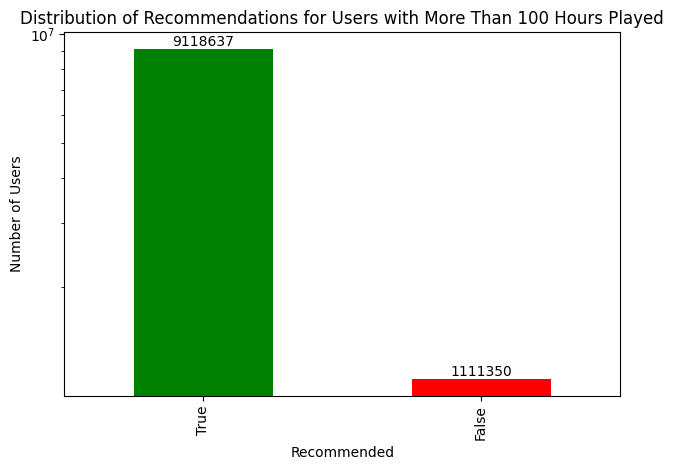

In [28]:
# Save those users with more than 100 hours played
high_activity_users = recommendations[recommendations['hours'] > 100]

# Count how many is_recomended reviews were made by those users
recommendation_counts = high_activity_users['is_recommended'].value_counts()
recommendation_counts.plot(kind='bar', color=['green', 'red'])

print(recommendation_counts)

# Plot the distribution of recommendations for users with more than 100 hours played
for i, count in enumerate(recommendation_counts):
    plt.text(i, count + 1000, str(count), ha='center', va='bottom')
plt.title('Distribution of Recommendations for Users with More Than 100 Hours Played')
plt.xlabel('Recommended')
plt.ylabel('Number of Users')
plt.yscale('log')
plt.tight_layout()

### 1.3 - Adapting data

In [29]:
# Create a new dataframe joining the games and games_metadata dataframes
merged_data = pd.merge(games,games_metadata,on='app_id',how='inner')
merged_data.columns

Index(['app_id', 'title', 'date_release', 'win', 'mac', 'linux', 'rating',
       'positive_ratio', 'user_reviews', 'price_final', 'price_original',
       'discount', 'steam_deck', 'release_year', 'price_category',
       'description', 'tags'],
      dtype='object')

In [30]:
# Select those columns that are relevant for the recommendation system
df = merged_data[['app_id','title','description','tags','rating']]
df.head()

,app_id,title,description,tags,rating
0,13500,Prince of Persia: Warrior Within™,Enter the dark underworld of Prince of Persia ...,"[Action, Adventure, Parkour, Third Person, Gre...",Very Positive
1,22364,BRINK: Agents of Change,,[Action],Positive
2,113020,Monaco: What's Yours Is Mine,Monaco: What's Yours Is Mine is a single playe...,"[Co-op, Stealth, Indie, Heist, Local Co-Op, St...",Very Positive
3,226560,Escape Dead Island,Escape Dead Island is a Survival-Mystery adven...,"[Zombies, Adventure, Survival, Action, Third P...",Mixed
4,249050,Dungeon of the ENDLESS™,Dungeon of the Endless is a Rogue-Like Dungeon...,"[Roguelike, Strategy, Tower Defense, Pixel Gra...",Very Positive


In [31]:
# Take each list of tags and join them into a single string
df['tags'] = df['tags'].apply(lambda x: ' '.join(x))
# Join the title the description and the tags into a single string
df['overview'] = df['title'] + " " + df['description'] + " " + df['tags']
df.head()

/tmp/ipykernel_1322598/893991118.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tags'] = df['tags'].apply(lambda x: ' '.join(x))
/tmp/ipykernel_1322598/893991118.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['overview'] = df['title'] + " " + df['description'] + " " + df['tags']


,app_id,title,description,tags,rating,overview
0,13500,Prince of Persia: Warrior Within™,Enter the dark underworld of Prince of Persia ...,Action Adventure Parkour Third Person Great So...,Very Positive,Prince of Persia: Warrior Within™ Enter the da...
1,22364,BRINK: Agents of Change,,Action,Positive,BRINK: Agents of Change Action
2,113020,Monaco: What's Yours Is Mine,Monaco: What's Yours Is Mine is a single playe...,Co-op Stealth Indie Heist Local Co-Op Strategy...,Very Positive,Monaco: What's Yours Is Mine Monaco: What's Yo...
3,226560,Escape Dead Island,Escape Dead Island is a Survival-Mystery adven...,Zombies Adventure Survival Action Third Person...,Mixed,Escape Dead Island Escape Dead Island is a Sur...
4,249050,Dungeon of the ENDLESS™,Dungeon of the Endless is a Rogue-Like Dungeon...,Roguelike Strategy Tower Defense Pixel Graphic...,Very Positive,Dungeon of the ENDLESS™ Dungeon of the Endless...


In [32]:
# Now lets map the ratings to numerical values
# Create a mapping dictionary
rating_map = {
    'Overwhelmingly Negative': 0,
    'Very Negative': 1,
    'Mostly Negative': 2,
    'Negative': 3,
    'Mixed': 4,
    'Positive': 5,
    'Mostly Positive': 6,
    'Very Positive': 7,
    'Overwhelmingly Positive': 8
}

# Map the textual ratings to numerical values
df['numerical_rating'] = df['rating'].map(rating_map)
df.head()

/tmp/ipykernel_1322598/76139293.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['numerical_rating'] = df['rating'].map(rating_map)


,app_id,title,description,tags,rating,overview,numerical_rating
0,13500,Prince of Persia: Warrior Within™,Enter the dark underworld of Prince of Persia ...,Action Adventure Parkour Third Person Great So...,Very Positive,Prince of Persia: Warrior Within™ Enter the da...,7
1,22364,BRINK: Agents of Change,,Action,Positive,BRINK: Agents of Change Action,5
2,113020,Monaco: What's Yours Is Mine,Monaco: What's Yours Is Mine is a single playe...,Co-op Stealth Indie Heist Local Co-Op Strategy...,Very Positive,Monaco: What's Yours Is Mine Monaco: What's Yo...,7
3,226560,Escape Dead Island,Escape Dead Island is a Survival-Mystery adven...,Zombies Adventure Survival Action Third Person...,Mixed,Escape Dead Island Escape Dead Island is a Sur...,4
4,249050,Dungeon of the ENDLESS™,Dungeon of the Endless is a Rogue-Like Dungeon...,Roguelike Strategy Tower Defense Pixel Graphic...,Very Positive,Dungeon of the ENDLESS™ Dungeon of the Endless...,7


In [33]:
df.shape

(50872, 7)

In [34]:
# Set the final dataframe we will use for the recommendation system
final_df = df[['app_id','title','numerical_rating','overview']]
final_df.head()

,app_id,title,numerical_rating,overview
0,13500,Prince of Persia: Warrior Within™,7,Prince of Persia: Warrior Within™ Enter the da...
1,22364,BRINK: Agents of Change,5,BRINK: Agents of Change Action
2,113020,Monaco: What's Yours Is Mine,7,Monaco: What's Yours Is Mine Monaco: What's Yo...
3,226560,Escape Dead Island,4,Escape Dead Island Escape Dead Island is a Sur...
4,249050,Dungeon of the ENDLESS™,7,Dungeon of the ENDLESS™ Dungeon of the Endless...


## 2 - Training the model

To train the model we will use the library SentenceTransformer with the model all-MiniLM-L6-v2 to transform the sentences of the overview into tokens and faiss, a similar method to cosine similarity but from facebook that requires much less memory to get the similarity between videogames. But first, we will start adapting the overview words to be able to tokenize them

In [35]:
# Create a function to remove special characters from the overview
import re 

def remove_special_characters(text):
    # \w matches any word character (alphanumeric & underscore).
    # \s matches any whitespace character (spaces, tabs, line breaks).
    return re.sub(r'[^\w\s]', '', text)

In [36]:
# Clean the overview column and convert to lowercase
df['overview'] = df['overview'].apply(lambda x: remove_special_characters(x))
df['overview'] = df['overview'].apply(lambda x: x.lower())

/tmp/ipykernel_1322598/3782279336.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['overview'] = df['overview'].apply(lambda x: remove_special_characters(x))
/tmp/ipykernel_1322598/3782279336.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['overview'] = df['overview'].apply(lambda x: x.lower())


In [ ]:
# Once we have the overview cleaned and stemmed, we will use the SentenceTransformer along with the model all-MiniLM-L6-v2 to convert the overview into a matrix of token counts
from sentence_transformers import SentenceTransformer

# Load the pretrained model
model = SentenceTransformer('all-MiniLM-L6-v2')

/home/pedro/Master_python/TFM/tfmenv/lib/python3.10/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
/home/pedro/Master_python/TFM/tfmenv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [38]:
# Create the sentence embeddings and reduce the data type to float32 to save memory
vectors = model.encode(df['overview'].tolist(), show_progress_bar=True)
vectors = np.array(vectors, dtype=np.float32)

Batches:   0%|          | 0/1590 [00:00<?, ?it/s]

In [39]:
# Show the shape and type of the vectors
print(vectors.shape)
print(type(vectors))

(50872, 384)
<class 'numpy.ndarray'>


In [40]:
# As cosine similarity requires too much memory, we will use FAISS (Facebook AI Similarity Search) trying to reduce the memory usage
import faiss
# Create a FAISS index (it doesn't save the vectors in memory, only the indexes)
# We will use the IndexFlatIP index, which is an index for inner product similarity search (cosine similarity)
index = faiss.IndexFlatIP(vectors.shape[1])
# Add the vectors to the index
index.add(vectors)


In [41]:
# Finally we create a function that will return the top 10 recommendations for a given game without using games ratings
def recommend(game):
    # Get the index of the game
    game_index = final_df[final_df['title'] == game].index[0]
    # Get the similarity vector of the corresponding game
    query_vector = vectors[game_index].reshape(1, -1)
    # Look for the 10 most similar games (including the game itself)
    distances, indexes = index.search(query_vector, 11) # Return 11 games, as the first one is the game itself
    # Remove the game itself from the list
    game_list = indexes[0][1:]
    # Return the top 10 recommendations
    for i in game_list:
        print(final_df.iloc[i]['title'])

In [53]:
# This second version of the function will return the top 10 recommendations for a given game using games ratings
def recommend_v2(game):
    # Get the index of the game
    game_index = final_df[final_df['title'] == game].index[0]
    # Get the similarity vector of the corresponding game
    query_vector = vectors[game_index].reshape(1, -1)
    # Look for the 10 most similar games (including the game itself)
    distances, indexes = index.search(query_vector, 31) # Return 21 games, as the first one is the game itself
    # Remove the game itself from the list
    game_list = indexes[0][1:]
    distances = distances[0][1:]

    # Get the average user rating for each game
    game_ratings = final_df.iloc[game_list]['numerical_rating']

    # Create a list of games with indexes, ratings and distances
    games = list(zip(game_list, game_ratings, distances))

    # Order by rating and distance in case of a tie
    sorted_games = sorted(games, key=lambda x: (-x[1], x[2]))

    # Get the indexes of the top 10 recommendations
    top_games = sorted_games[:10]
    # print(top_games)

    # Return the top 10 recommendations
    for i,_,_ in top_games:
        print(final_df.iloc[i]['title'])

In [55]:
# Create a function to search for games by title
def search_game(query):
    # Convert the query to lowercase for case-insensitive search
    query = query.lower()
    # Filter the dataframe for titles that start with or contain the query string
    result = final_df[final_df['title'].str.lower().str.contains(query)]
    return result

# Find a game in the dataset
search_game("dark souls")

,app_id,title,numerical_rating,overview
6086,271943,DARK SOULS™ II Crown of the Old Iron King,7,DARK SOULS™ II Crown of the Old Iron King RPG...
9429,236430,DARK SOULS™ II,7,DARK SOULS™ II
13272,335300,DARK SOULS™ II: Scholar of the First Sin,7,DARK SOULS™ II: Scholar of the First Sin
13467,506971,DARK SOULS™ III - The Ringed City™,7,DARK SOULS™ III - The Ringed City™ Dark Fanta...
13554,271944,DARK SOULS™ II Crown of the Ivory King,7,DARK SOULS™ II Crown of the Ivory King Action...
15268,570940,DARK SOULS™: REMASTERED,7,DARK SOULS™: REMASTERED
16071,374320,DARK SOULS™ III,7,DARK SOULS™ III
17102,506970,DARK SOULS™ III - Ashes of Ariandel™,4,DARK SOULS™ III - Ashes of Ariandel™ Dark Fan...
26762,284450,DARK SOULS™ II - Season Pass,7,DARK SOULS™ II - Season Pass RPG Action Dark ...
29250,271942,DARK SOULS™ II Crown of the Sunken King,6,DARK SOULS™ II Crown of the Sunken King RPG A...


In [56]:
# Now we will test the recommendation system
recommend("DARK SOULS™ II")

DARK SOULS™ III
DARK SOULS™: REMASTERED
DARK SOULS™ II Crown of the Old Iron King
Darkest Dungeon® II
DARK SOULS™ II Crown of the Ivory King
DARK SOULS™: Prepare To Die™ Edition
DARK SOULS™ II: Scholar of the First Sin
DARK SOULS™ II Crown of the Sunken King
DARK SOULS™ II - Season Pass
DARK SOULS™ III - Season Pass


In [57]:
# Now we will test the recommendation system
recommend_v2("DARK SOULS™ II")

Resident Evil 2
Borderlands 2
The Legend of Dark Witch 2 （魔神少女エピソード２）
Dark Deception Chapter 2
Soul Survivors
The Darkness II
Destiny 2
DARK SOULS™ III - The Ringed City™
DARK SOULS™ II - Season Pass
DARK SOULS™ II: Scholar of the First Sin
